The following is an application of machine learning using the k-nearest neighbors algorithm to predict a car's market price. The data set comes from UCI's machine learning repository and includes attributes of a typical car. 

My process began with narrowing down my data set to include attributes that were most predictive of a car's market value. I then cleaned the data by removing unnecessary punctuation, converting data types and replacing null values.

In [2]:
import pandas as pd
import numpy as np
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv('imports-85.data',names=cols)
print(cars.head())

   symboling normalized-losses         make fuel-type aspiration num-of-doors  \
0          3                 ?  alfa-romero       gas        std          two   
1          3                 ?  alfa-romero       gas        std          two   
2          1                 ?  alfa-romero       gas        std          two   
3          2               164         audi       gas        std         four   
4          2               164         audi       gas        std         four   

    body-style drive-wheels engine-location  wheel-base  ...    engine-size  \
0  convertible          rwd           front        88.6  ...            130   
1  convertible          rwd           front        88.6  ...            130   
2    hatchback          rwd           front        94.5  ...            152   
3        sedan          fwd           front        99.8  ...            109   
4        sedan          4wd           front        99.4  ...            136   

   fuel-system  bore  stroke compressi

In [3]:
cars[cars['normalized-losses'] == '?'].shape[0]
cars_cont_col = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
continuous_cars = cars[cars_cont_col]

In [4]:
new_cars = continuous_cars.replace('?',np.nan)

In [5]:
new_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 14 columns):
normalized-losses    164 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
bore                 201 non-null object
stroke               201 non-null object
compression-rate     205 non-null float64
horsepower           203 non-null object
peak-rpm             203 non-null object
city-mpg             205 non-null int64
highway-mpg          205 non-null int64
price                201 non-null object
dtypes: float64(5), int64(3), object(6)
memory usage: 22.5+ KB


In [6]:
new_cars = new_cars.astype('float')
new_cars.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [7]:
new_cars = new_cars.dropna(subset=['price'])

In [8]:
new_cars.isnull().sum()

normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

Instead of dropping all remaining rows with null values, I filled the empty rows with mean values of each column. 

In [9]:
new_cars = new_cars.fillna(new_cars.mean())

In [10]:
new_cars.isnull().sum()
price_col = new_cars['price']

In [11]:
normal_cars = (new_cars - new_cars.mean())/new_cars.std()
normal_cars['price'] = price_col

Behold our clean, normalized data set!

In [12]:
normal_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.000000,-1.680910,-0.438315,-0.851335,-2.029015,-0.014821,0.519597,-1.825369,-0.290709,0.203476,-0.245942,-0.650624,-0.540937,13495.0
1,0.000000,-1.680910,-0.438315,-0.851335,-2.029015,-0.014821,0.519597,-1.825369,-0.290709,0.203476,-0.245942,-0.650624,-0.540937,16500.0
2,0.000000,-0.708334,-0.243544,-0.185134,-0.558319,0.516789,-2.427374,0.674254,-0.290709,1.354267,-0.245942,-0.961995,-0.687669,16500.0
3,1.312654,0.165335,0.194690,0.147966,0.217881,-0.422710,-0.524899,0.452769,-0.041019,-0.037387,0.799836,-0.183569,-0.100741,13950.0
4,1.312654,0.099398,0.194690,0.243137,0.217881,0.518722,-0.524899,0.452769,-0.540399,0.310527,0.799836,-1.117680,-1.274597,17450.0


Now that the data is clean, we can move on to the actual predictions.

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

Next, I define a function that takes as input a set of columns on which to train my model, the target column I'm looking to predict, and a dataframe. The output is the squared error between the actual target values and predicted target values.

In [17]:
features = ['normalized-losses','horsepower','city-mpg','highway-mpg']

def knn_train_test(train,target,df):
    #The function must first split the data into training and testing sets.
    first = int(round(df.shape[0]*.5,0))
    #Next, it randomizes the values in the dataset to avoid bias based on its initial ordering.
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    train_df = rand_df.iloc[:first]
    test_df = rand_df.iloc[first:]
    #Then the machine learning kicks in. The function instantiates a KNeighborsRegressor class, fits the model 
    #on a training set and then makes a prediction based on my target column.
    knn = KNeighborsRegressor()
    knn.fit(train_df[[train]],train_df[target])
    prediction = knn.predict(test_df[[train]])
    #The final output is a root mean squared error describing the squared difference between our target values and predicted
    #values created by the model.
    rmse = np.sqrt(mean_squared_error(test_df[target],prediction))
    return rmse

The next step is to use my function to determine which columns perform the best. My 'best', I mean which produce the lowest error value between actual and predicted market price.

In [18]:
train_cols = normal_cars.columns.drop('price')
rmse_results = {}

for col in train_cols:
    rmse = knn_train_test(col,'price',normal_cars)
    rmse_results[col] = rmse
    

rmse_results_series = pd.Series(rmse_results)
rmse_results_series.sort_values()

horsepower           4047.376555
curb-weight          4453.680703
highway-mpg          4625.047587
city-mpg             4754.637378
width                4772.510209
length               5429.644740
wheel-base           5461.490336
compression-rate     6606.571346
bore                 6793.057484
normalized-losses    7337.284820
peak-rpm             7643.070323
stroke               8006.096427
height               8132.467732
dtype: float64

To enhance my model's precision, I want to determine which value of k is optimal. In other words, I want to see how many nearby values are necessary to ensure the most accurate prediction. To do so, I embedded a 'for' loop in my function, which iterates through a list of k values and outputs a dictionary which contains an input column as key and a list of squared errors corresponding to each value of k. 

In [19]:
def knn_train_test(train,target,df):
    first = int(round(df.shape[0]*.5,0))
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    train_df = rand_df.iloc[:first]
    test_df = rand_df.iloc[first:]
    
    k_list = [1,3,5,7,9]
    k_rmses = {}
    
    for k in k_list:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[[train]],train_df[target])
        prediction = knn.predict(test_df[[train]])
        rmse = np.sqrt(mean_squared_error(test_df[target],prediction))
        
        k_rmses[k] = rmse
    return k_rmses

In [20]:
train_cols = normal_cars.columns.drop('price')
rmse_results = {}

for col in train_cols:
        rmse = knn_train_test(col,'price',normal_cars)
        rmse_results[col] = rmse

I iterated through each column and value of k to produce a rather large dictionary with squared errors corresponding to each column and value of k. To easier comprehend my results, I mapped these values to a line chart. 

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

rmse_results

{'bore': {1: 8602.58848450066,
  3: 6977.123411794459,
  5: 6793.0574839170895,
  7: 6828.8678082042015,
  9: 6865.299025218018},
 'city-mpg': {1: 5901.143574354764,
  3: 4608.180446380397,
  5: 4754.637378183515,
  7: 5035.456896910003,
  9: 5333.1616578530175},
 'compression-rate': {1: 8083.070177540802,
  3: 7379.623321663306,
  5: 6606.571345933599,
  7: 6732.032905446027,
  9: 7019.9512505224375},
 'curb-weight': {1: 5288.0195725810245,
  3: 5011.8789151002,
  5: 4453.680702653493,
  7: 4330.149364501495,
  9: 4632.92525121302},
 'height': {1: 8904.04645636071,
  3: 8277.609643045525,
  5: 8132.467731772246,
  7: 7704.344964170201,
  9: 7779.56469282989},
 'highway-mpg': {1: 6025.594966720739,
  3: 4627.908507167689,
  5: 4625.047587445843,
  7: 4722.975580907234,
  9: 5201.019510000462},
 'horsepower': {1: 4170.054848037801,
  3: 4010.5218032337666,
  5: 4047.376554982472,
  7: 4383.729138557079,
  9: 4505.9694416104885},
 'length': {1: 4577.003915399697,
  3: 5087.460276710444,


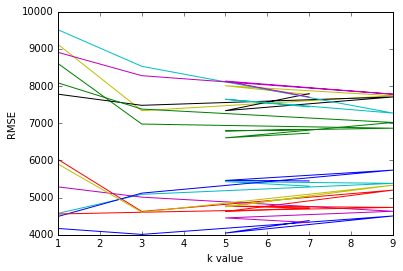

In [22]:
for k,v in rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')

While the results vary, it appears the k value that yields the lowest error for each column is 5, which is the function's default.

Next, I want to plug in multiple columns to determine what combination is most predictive at the default k value. To do so, I remove the loop from my prior function.

In [23]:
def knn_train_test(train_cols,target,df):
    first = int(round(df.shape[0]*.5,0))
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    train_df = rand_df.iloc[:first]
    test_df = rand_df.iloc[first:]
    
    k_list = [1,3,5,7,9]
    k_rmses = {}
    
    #for k in k_list:
    knn = KNeighborsRegressor()
    knn.fit(train_df[train_cols],train_df[target])
    prediction = knn.predict(test_df[train_cols])
    rmse = np.sqrt(mean_squared_error(test_df[target],prediction))
        
    k_rmses[k] = rmse
    return k_rmses

I plugged in the columns with the lowest error values, starting with the best two and moving up to include the best five. I stored each result in a dictionary, and then stored all of those results in a larger dictionary.a

In [24]:
new_rmse_results = {}

two_best = ['width','horsepower']
rmse_val = knn_train_test(two_best,'price',normal_cars)
new_rmse_results['two best'] = rmse_val

three_best = ['width','horsepower','curb-weight']
rmse_val = knn_train_test(three_best,'price',normal_cars)
new_rmse_results['three best'] = rmse_val

four_best = ['width','horsepower','curb-weight','highway-mpg']
rmse_val = knn_train_test(four_best,'price',normal_cars)
new_rmse_results['four best'] = rmse_val

five_best = ['width','horsepower','curb-weight','highway-mpg','city-mpg']
rmse_val = knn_train_test(five_best,'price',normal_cars)
new_rmse_results['five best'] = rmse_val


Our results show that the three best columns - width, horsepower, and curb-weight - yield the lowest error value and are thus the most predictive when taken together at the default k value. 

In [25]:
new_rmse_results

{'five best': {'city-mpg': 3346.3794863306603},
 'four best': {'city-mpg': 3364.4454402465853},
 'three best': {'city-mpg': 3315.179311728235},
 'two best': {'city-mpg': 3587.6781582974736}}

As a final step, I modified my function to vary the k value from 1 to 25, in order to determine the optimal k value and optimal number of columns to include.

In [26]:
def knn_train_test(train_cols,target,df):
    first = int(round(df.shape[0]*.5,0))
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    train_df = rand_df.iloc[:first]
    test_df = rand_df.iloc[first:]
    
    k_list = list(range(1,25))
    k_rmses = {}
    
    for k in k_list:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols],train_df[target])
        prediction = knn.predict(test_df[train_cols])
        rmse = np.sqrt(mean_squared_error(test_df[target],prediction))
        
        k_rmses[k] = rmse
    return k_rmses

In [27]:
n_rmse_results = {}

three_best = ['width','horsepower','curb-weight']
rmse_val = knn_train_test(three_best,'price',normal_cars)
n_rmse_results['three best'] = rmse_val

four_best = ['width','horsepower','curb-weight','highway-mpg']
rmse_val = knn_train_test(four_best,'price',normal_cars)
n_rmse_results['four best'] = rmse_val

five_best = ['width','horsepower','curb-weight','highway-mpg','city-mpg']
rmse_val = knn_train_test(five_best,'price',normal_cars)
n_rmse_results['five best'] = rmse_val

I ran my model using the three best up to the five best columns, and stored my results in a dictionary. Each key corresponds to the number of columns included, and the values are a list of squared errors corresponding to a value of k between 1 and 25. 

In [31]:
n_rmse_results

{'five best': {1: 2536.2720615693083,
  2: 2959.813922017784,
  3: 3111.229799225117,
  4: 3199.3074433313604,
  5: 3346.3794863306603,
  6: 3675.5840031247285,
  7: 3881.6214585276716,
  8: 3987.024841118288,
  9: 3986.2156175243376,
  10: 4154.4568632391465,
  11: 4317.598994123106,
  12: 4477.41729844312,
  13: 4497.021859534609,
  14: 4461.661821749708,
  15: 4492.38034637069,
  16: 4552.763836478077,
  17: 4585.976537861621,
  18: 4644.4509283481775,
  19: 4646.0064290900345,
  20: 4661.95649416,
  21: 4754.46158569013,
  22: 4809.777569391321,
  23: 4826.84825961205,
  24: 4873.1290634705765},
 'four best': {1: 2586.502746073459,
  2: 2828.392180940953,
  3: 3077.1371106240554,
  4: 3199.1386762380243,
  5: 3364.4454402465853,
  6: 3616.3833918202954,
  7: 3861.022796953374,
  8: 4050.0264938474584,
  9: 4071.0341714401775,
  10: 4212.593894643551,
  11: 4273.165431772904,
  12: 4410.265774344844,
  13: 4456.848653835364,
  14: 4424.140601675838,
  15: 4445.740618962054,
  16: 45

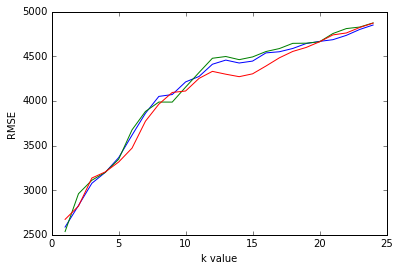

In [33]:
for k,v in n_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')

There are two takeaways from these results:
1) As our k values increase, our model yields larger errors, leading me to conclude that this feature is more influential than any number of features we choose to include.
2) The model yielding the lowest error learns from five predictors - width,horsepower,curb-weight,highway-mpg,city-mpg - but only for a k value of 1. 
3) It makes most sense to keep our k value at the default value or lower for this model, as this seems to be the best outcome achieved through the most practical methodology. 